# Importing needed libraries

In [1]:
import cv2
import imutils
from numpy.linalg import norm
import numpy as np
cv2.__version__
import matplotlib.pyplot as plt

# Image import

In [2]:
image = cv2.imread('paragon_2.jpg')
image.shape

(600, 450, 3)

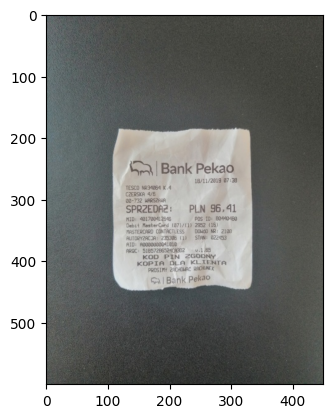

In [3]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Reducing the image

In [4]:
orginal_image = image.copy()
ratio = image.shape[0] / 500.0
image = imutils.resize(image, height=500)
image.shape

(500, 375, 3)

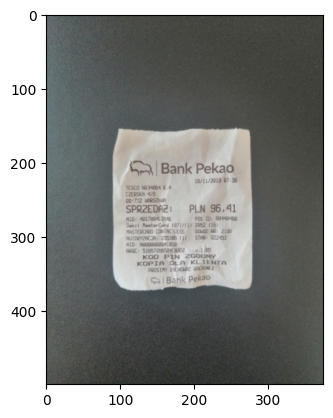

In [5]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Morphological operation

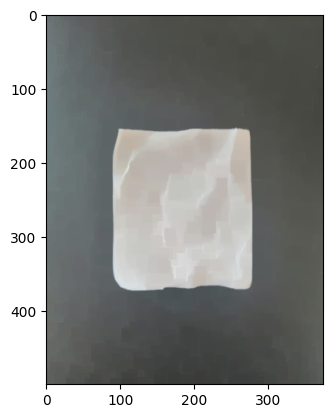

In [6]:
kernel = np.ones((5,5),np.uint8)
img = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations= 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

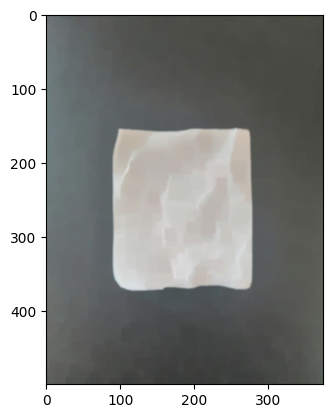

In [7]:
img = cv2.GaussianBlur(img, (3,3),0)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# GrabCut operation

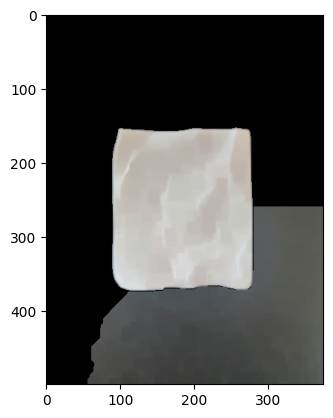

In [8]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (20,20,img.shape[1]-20,img.shape[0]-20)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Edge Detection

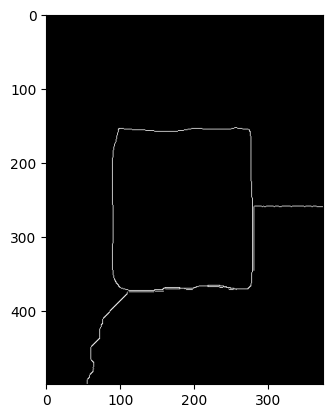

In [9]:
edges = cv2.Canny(img, threshold1=75, threshold2=200)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))

In [10]:
contours = cv2.findContours(image=edges.copy(), mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
print(f'Number of all found points (contour): {len(contours)}')
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
len_contours = len(contours)

for contour in contours:
    print(len(contour))

Number of all found points (contour): 9
131
110
60
6
6


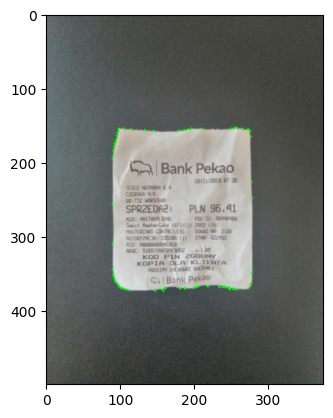

In [11]:
cnt1 = cv2.drawContours(image.copy(), contours[0], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(cnt1, cv2.COLOR_BGR2RGB))

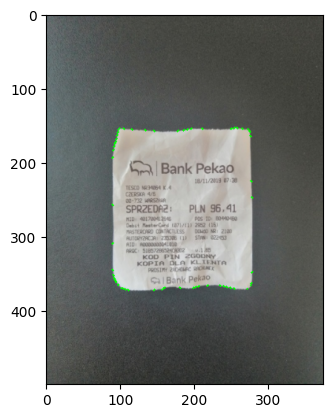

In [12]:
cnt2 = cv2.drawContours(image.copy(), contours[1], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(cnt2, cv2.COLOR_BGR2RGB))

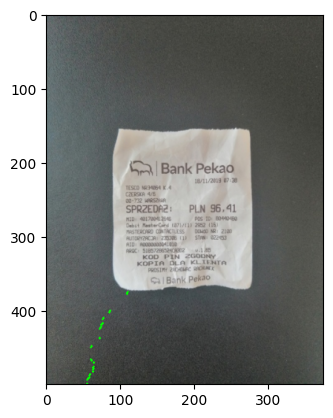

In [13]:
cnt3 = cv2.drawContours(image.copy(), contours[2], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(cnt3, cv2.COLOR_BGR2RGB))

# Detecting the Corner Points

In [14]:
for contour in contours:
    print('Verification...')
    perimeter = cv2.arcLength(curve=contour, closed=True)
    
    approx = cv2.approxPolyDP(curve=contour, epsilon=0.02 * perimeter, closed=True)

    if len(approx) ==4:
        screen_contour = approx
        break
    
print(screen_contour)

Verification...
[[[274 156]]

 [[ 97 155]]

 [[ 99 369]]

 [[276 367]]]


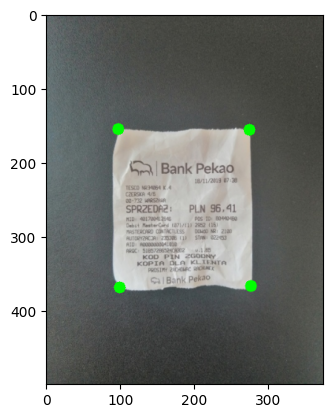

In [15]:
cv2.drawContours(image, screen_contour, -1, (0, 255, 0), 15)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Restoring the scale

In [16]:
points = screen_contour.reshape(4, 2)
points = points * ratio
points

array([[328.8, 187.2],
       [116.4, 186. ],
       [118.8, 442.8],
       [331.2, 440.4]])

# Rearranging the Detected Corners

In [17]:
rectanle = np.zeros((4, 2), dtype='float32')
rectanle

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [18]:
total = points.sum(axis=1)

rectanle[0] = points[np.argmin(total)]
rectanle[2] = points[np.argmax(total)]
rectanle

array([[116.4, 186. ],
       [  0. ,   0. ],
       [331.2, 440.4],
       [  0. ,   0. ]], dtype=float32)

In [19]:
difference = np.diff(points, axis=1)
rectanle[1] = points[np.argmin(difference)]
rectanle[3] = points[np.argmax(difference)]
rectanle

array([[116.4, 186. ],
       [328.8, 187.2],
       [331.2, 440.4],
       [118.8, 442.8]], dtype=float32)

In [20]:
(a, b, c, d) = rectanle

width1 = norm(c - b)
width2 = norm(b - a)
max_width = max(int(width1), int(width2))

hight1 = norm(b - c)
hight2 = norm(a - d)
max_hight = max(int(hight1), int(hight2))

print(f'max_width: {max_width}')
print(f'max_hight: {max_hight}')

max_width: 253
max_hight: 256


In [21]:
vertices = np.array([
    [0, 0],
    [max_width -1, 0],
    [max_width -1, max_hight -1],
    [0, max_hight -1]
], dtype='float32')
    
vertices

array([[  0.,   0.],
       [252.,   0.],
       [252., 255.],
       [  0., 255.]], dtype=float32)

# Perspective Transform to Align the Document

In [22]:
M =cv2.getPerspectiveTransform(rectanle, vertices)
M

array([[ 1.16121931e+00, -1.08525243e-02, -1.33147359e+02],
       [-5.56979869e-03,  9.85856811e-01, -1.82721042e+02],
       [-6.55131012e-05,  1.23371183e-06,  1.00000000e+00]])

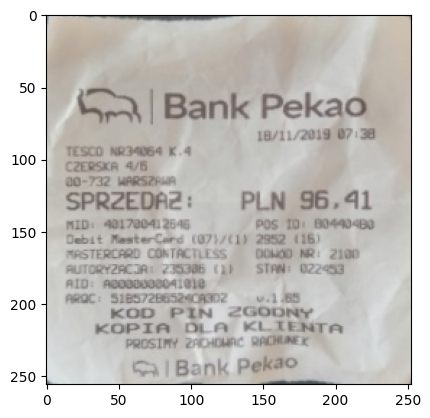

In [23]:
out = cv2.warpPerspective(src=orginal_image, M=M, dsize=(max_width, max_hight))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))